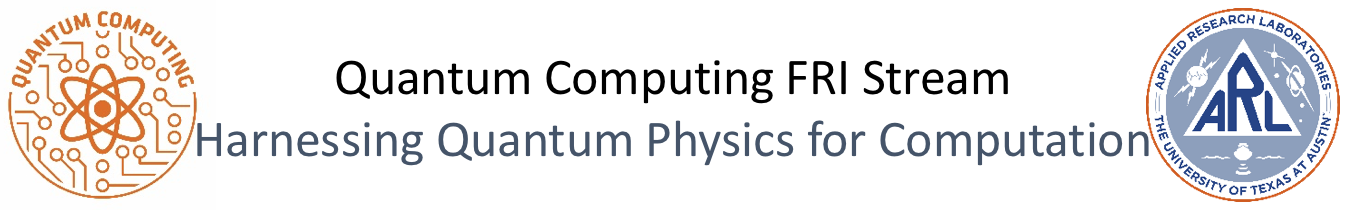

#### Most Recent Lesson: Lesson18 - Perfect Quantum Error Correction

### Installations and Imports

In [1]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

     |████████████████████████████████| 4.8 MB 11.3 MB/s 
     |████████████████████████████████| 12.8 MB 6.9 MB/s 
     |████████████████████████████████| 240 kB 54.1 MB/s 
     |████████████████████████████████| 106 kB 64.6 MB/s 
     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 50 kB 3.4 MB/s 
     |████████████████████████████████| 49 kB 3.5 MB/s 
     |████████████████████████████████| 37.5 MB 374 kB/s 
     |████████████████████████████████| 929 kB 42.5 MB/s 
     |████████████████████████████████| 4.0 MB 59.6 MB/s 
     |████████████████████████████████| 1.9 MB 46.4 MB/s 
     |████████████████████████████████| 112 kB 50.2 MB/s 
     |████████████████████████████████| 162 kB 31.0 MB/s 


In [2]:
#Let's go ahead and import all this stuff too
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
import numpy as np

In [3]:
def rand(a=0, b=1):
    return a + (b-a)*np.random.random()

# Perfect Quantum Error Correction

Use this notebook to implement a QEC protocol that will do the following:
- Prepare a random single-qubit state.
- Encode the qubit using the 5-qubit perfect code.
- Add a syndrome register (auxiliary qubits) and apply gates to diagnose a syndrome.
- Measure the syndrome and use conditional gates to correct the error.
- Then do it without measuring by using controlled gates.
- Recall that $\texttt{qc.x(q[0]).c_if(c,2)}$ applies a NOT gate to qubit 0 of the quantum register q if the classical register c is such that $\texttt{c[1] = 1}$ and $\texttt{c[0]= 0}$ (i.e., c = 2 in decimal form).

## Helper Functions
**You may use these if you do not wish to use the qiskit functions to add controls to gates. You do not need to edit these**

The following functions implement special controlled $X, Y, Z$ gates, called multiCX, multiCY, multiCZ, respectively.  Each function takes as its input a quantum register "q_controls" with n control qubits and a quantum register "q_target" with 1 target qubit.  It also has, as an optional argument, a "signature" sig, which is an array with $n$ binary elements.  The controlled gate is applied to q_target only if q_controls[i] = sig[i] for all $i = 0, ..., n-1$.  By default, sig is an array of all ones.

In [18]:
def multiPhase(qc, q, theta):
    # multi-qubit controlled phase rotation
    # applies a phase factor exp(i*theta) if all the qubits are 1.
    # Note that it doesn't matter which qubits are the controls and which is the target.
    # qc is a quantum circuit
    # q is a quantum register in qc
    # theta is a float
    n = len(q)
    q = [q[i] for i in range(n)]
    if n == 1:
        qc.u1(theta, q[0])
    elif n == 2:
        qc.cu1(theta, q[0], q[1])
    else:
        qc.cu1(theta/2, q[1], q[0])        
        multiCX(qc, q[2:], q[1])
        qc.cu1(-theta/2, q[1], q[0])
        multiCX(qc, q[2:], q[1])
        multiPhase(qc, [q[0]]+q[2:], theta/2)
        
    return
        
def multiCZ(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled Z gate
    # applies a Z gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])
    
    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n
    
    # apply signature
    for i in range(n):
        if sig[i] == 0:
            qc.x(q_controls[i])
    
    q = [q_controls[i] for i in range(len(q_controls))] + [q_target]
    multiPhase(qc, q, np.pi)
    
    # undo signature gates
    for i in range(n):
        if sig[i] == 0:
            qc.x(q_controls[i])
    
    return
        
def multiCX(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled X gate
    # applies an X gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])
    
    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n
            
    # use the fact that H Z H = X to realize a controlled X gate
    qc.h(q_target)
    multiCZ(qc, q_controls, q_target, sig)
    qc.h(q_target)
            
    return
    
def multiCY(qc, q_controls, q_target, sig=None):
    # multi-qubit controlled Y gate
    # applies a Y gate to q_target if q_controls[i]==sig[i] for all i
    # qc is a quantum circuit
    # q_controls is the quantum register of the controlling qubits
    # q_target is the quantum register of the target qubit
    # sig is the signature of the control (defaults to sig=[1,1,...,1])
    
    # default signature is an array of n 1s
    n = len(q_controls)
    if sig is None:
        sig = [1] * n
            
    # use the fact that X Z = -i Y to realize a controlled Y gate
    multiCX(qc, q_controls, q_target, sig)
    multiCZ(qc, q_controls, q_target, sig)
            
    return

## Encoding and Decoding

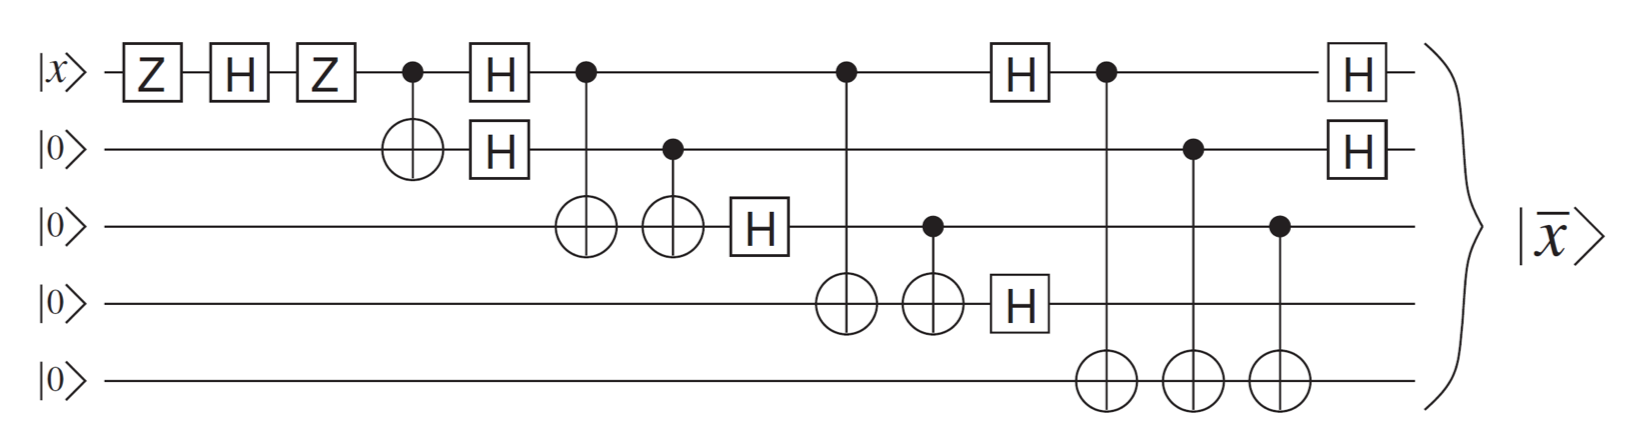

In [4]:
def perfect_encoding(qc, qx):
    # Encode qubit qx[0] using the five-qubit "perfect" code.
    # Put your code here.
    qc.z(qx[0])
    qc.h(qx[0])
    qc.z(qx[0])
    qc.cx(qx[0],qx[1])
    qc.barrier()

    qc.h(qx[0:2])
    qc.cx(qx[0],qx[2])
    qc.cx(qx[1],qx[2])
    qc.h(qx[2])
    qc.barrier()

    qc.cx(qx[0],qx[3])
    qc.cx(qx[2],qx[3])
    qc.h(qx[0])
    qc.h(qx[3])
    qc.barrier()

    qc.cx(qx[0],qx[4])
    qc.cx(qx[1],qx[4])
    qc.cx(qx[2],qx[4])
    qc.barrier()

    qc.h(qx[0:2])
    qc.barrier()
       
    return 

In [5]:
def perfect_decoding(qc, qx):
    # Decode qubit qx[0] using the five-qubit "perfect" code.
    # Put your code here.
    pe = QuantumCircuit(qx)
    perfect_encoding(pe,qx)

    qc.compose(pe.inverse(),inplace="True")
    
    return 

## Error Model
**Do not modify**

In [10]:
def error_model(qc, qx, e=None, k=None):
    # Apply a random single-qubit error to one of the encoding qubits
    # DO NOT MODIFY!
    
    if (e is None):
        e = np.random.randint(0,5) # 0 = no error, 1 = X error, 2 = Y error, 3 = Z error, 4 = random unitary
    if (k is None):
        k = np.random.randint(0,5) # index of qubit on which error occurs
        
    if e == 0:
        print("no error")
        pass # no error - do nothing
    elif e == 1:
        print("X error on qubit " + str(k))
        qc.x(qx[k]) # bit-flip error on qubit k
    elif e == 2:
        print("Y error on qubit " + str(k))
        qc.y(qx[k]) # bit-flip & phase error on qubit k
    elif e == 3:
        print("Z error on qubit " + str(k))
        qc.z(qx[k]) # phase error on qubit k
    else:
        print("Random unitary on qubit " + str(k))
        theta = np.arccos(2*rand()-1)
        phi = 2*np.pi*rand()
        lamb = 2*np.pi*rand()
        qc.u(theta, phi, lamb, qx[k])

## Syndrome Measurement

$$\textbf{Stabilizers}$$

$$\begin{align}
\mathbf{M}_{0}=&\mathbf{Z}_{1}\mathbf{X}_{2}\mathbf{X}_{3}\mathbf{Z}_{4} \\
\mathbf{M}_{1}=&\mathbf{Z}_{2}\mathbf{X}_{3}\mathbf{X}_{4}\mathbf{Z}_{0} \\
\mathbf{M}_{2}=&\mathbf{Z}_{3}\mathbf{X}_{4}\mathbf{X}_{0}\mathbf{Z}_{1} \\
\mathbf{M}_{3}=&\mathbf{Z}_{4}\mathbf{X}_{0}\mathbf{X}_{1}\mathbf{Z}_{2} \\
\end{align}$$

In [6]:
def perfect_syndrome(qc, qx, qs):
    # Apply gates to "measure" the syndromes
    # Put your code here
    m0 = QuantumCircuit(qx, name="M0")
    m1 = QuantumCircuit(qx, name="M1")
    m2 = QuantumCircuit(qx, name="M2")
    m3 = QuantumCircuit(qx, name="M3")

    #M0 Circuit
    m0.z(qx[1])
    m0.x(qx[2])
    m0.x(qx[3])
    m0.z(qx[4])
    M0 = m0.to_gate().control()

    #M1 Circuit
    m1.z(qx[2])
    m1.x(qx[3])
    m1.x(qx[4])
    m1.z(qx[0])
    M1 = m1.to_gate().control()

    #M2 Circuit
    m2.z(qx[3])
    m2.x(qx[4])
    m2.x(qx[0])
    m2.z(qx[1])
    M2 = m2.to_gate().control()

    #M3 Circuit
    m3.z(qx[4])
    m3.x(qx[0])
    m3.x(qx[1])
    m3.z(qx[2])
    M3 = m3.to_gate().control()

    #applying each controlled unitary
    qc.h(qs)
    qc.append(M0, qs[0:1] + qx[:])
    qc.append(M1, qs[1:2] + qx[:])
    qc.append(M2, qs[2:3] + qx[:])
    qc.append(M3, qs[3:4] + qx[:])
    qc.h(qs)


    return

## Error Correction

In [25]:
def perfect_qec_conditionals(qc, qx, qs, cs):
    # Correct errors using measured syndromes and conditional gates
    # Put your code here.
    qc.measure(qs,cs)

    qc.z(qx[2]).c_if(cs,1)
    qc.x(qx[0]).c_if(cs,10)
    qc.z(qx[3]).c_if(cs,11)
    qc.x(qx[1]).c_if(cs,101)
    qc.x(qx[3]).c_if(cs,100)
    qc.z(qx[4]).c_if(cs,110)
    qc.y(qx[3]).c_if(cs,111)
    qc.z(qx[1]).c_if(cs,1000)
    qc.x(qx[4]).c_if(cs,1001)
    qc.x(qx[2]).c_if(cs,1010)
    qc.y(qx[2]).c_if(cs,1011)
    qc.z(qx[0]).c_if(cs,1100)
    qc.y(qx[1]).c_if(cs,1101)
    qc.y(qx[0]).c_if(cs,1110)
    qc.y(qx[4]).c_if(cs,1111)
    
    return

In [8]:
def perfect_qec_controls(qc, qx, qs):
    # Correct errors using controlled gates instead of conditional gates
    # Put your code here.
    multiCZ(qc,qs,qx[2], [1,0,0,0])
    multiCX(qc,qs,qx[0], [0,1,0,0])
    multiCZ(qc,qs,qx[3], [1,1,0,0])
    multiCX(qc,qs,qx[1], [1,0,1,0])
    multiCX(qc,qs,qx[3], [0,0,1,0])
    multiCZ(qc,qs,qx[4], [0,1,1,0])
    multiCY(qc,qs,qx[3], [1,1,1,0])
    multiCZ(qc,qs,qx[1], [0,0,0,1])
    multiCX(qc,qs,qx[4], [1,0,0,1])
    multiCX(qc,qs,qx[2], [0,1,0,1])
    multiCY(qc,qs,qx[2], [1,1,0,1])
    multiCZ(qc,qs,qx[0], [0,0,1,1])
    multiCY(qc,qs,qx[1], [1,0,1,1])
    multiCY(qc,qs,qx[0], [0,1,1,1])
    multiCY(qc,qs,qx[4], [1,1,1,1])
    
    return

## Main Code Block
This executes the entire protocol.

In [29]:
n = 5 # number of physical qubits
k = 1 # number of logical qubits

# prepare the quantum circuit
qx = qiskit.QuantumRegister(n)
qs = qiskit.QuantumRegister(n-k)
cx = qiskit.ClassicalRegister(n)
cs = qiskit.ClassicalRegister(n-k)
qc = qiskit.QuantumCircuit(qx, qs, cx, cs)

# prepare a random single-qubit state in qx[0]
theta = np.arccos(2*rand()-1)
phi = 2*np.pi*rand()
lamb = 0
qc.u(theta, phi, lamb, qx[0])

# encode the qubit using the 5-qubit perfect code
perfect_encoding(qc, qx)

# apply a random error to one of the encoding qubits
error_model(qc, qx,0)

# apply gates to perform a syndrome measurement
perfect_syndrome(qc, qx, qs)

# detect and correct error using the syndromes
perfect_qec_conditionals(qc, qx, qs, cs)
#perfect_qec_controls(qc, qx, qs)

# decode the corrected, encoded qubit
perfect_decoding(qc, qx)

# prepare qubit qx[0] for measurement
qc.u(theta, np.pi-lamb, np.pi-phi, qx[0])

# measure the qx register
for i in range(len(qx)):
    qc.measure(qx[i], cx[i])
    
# measure the qs register
for j in range(len(qs)):
    qc.measure(qs[j], cs[j])

# execute the quantum circuit
backend =  qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(qc, backend, shots=1024)
data = job.result().get_counts(qc)
print(data)

no error
{'0000 00000': 1024}
